# Use Python function to recognize hand-written digits with `ibm-watson-machine-learning`

Create and deploy a function that receives HTML canvas image data from a web app and then processes and sends that data to a model trained to recognize handwritten digits.  
See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deployed-func-mnist-tutorial.html" target="_blank">MNIST function deployment tutorial</a>  

This notebook runs on Python 3.9.

## Learning goals

The learning goals of this notebook are:

-  AI function definition
-  Store AI function
-  Deployment creation

## Contents

This notebook contains the following parts:
1. [Setup](#setup)
2. [Get an ID for a model deployment](#step4)
3. [Get sample canvas data](#step5)
4. [Create a deployable function](#upload)
5. [Store and deploy the function](#deploy)
6. [Test the deployed function](#score)
7. [Clean up](#cleanup)
8. [Summary](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact your Cloud Pack for Data administrator and ask them for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
wml_credentials = {
    "username": username,
    "apikey": api_key,
    "url": url,
    "instance_id": 'openshift',
    "version": '4.5'
}

Alternatively you can use `username` and `password` to authenticate WML services.

```
wml_credentials = {
    "username": ***,
    "password": ***,
    "url": ***,
    "instance_id": 'openshift',
    "version": '4.5'
}

```

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="https://ibm.github.io/watson-machine-learning-sdk//" target="_blank" rel="noopener no referrer">here</a>.

In [1]:
!pip install -U ibm-watson-machine-learning

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd4.5/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

## 2. <a id="step4"></a> Get an ID for a model deployment

The deployed function created in this notebook is designed to send payload data to a TensorFlow model created in the <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-mnist-tutorials.html" target="_blank" rel="noopener noreferrer">MNIST tutorials</a>.

In [5]:
import os, wget, json
import numpy as np
import matplotlib.pyplot as plt
import requests

### Option 1: Use your own, existing model deployment

If you already deployed a model while working through one of the following MNIST tutorials, you can use that model deployment:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_experiment-builder.html" target="_blank" rel="noopener noreferrer">Experiment builder MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_experiment-builder_hpo.html" target="_blank" rel="noopener noreferrer">Experiment builder (HPO) MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Python client (notebook) MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_cli.html" target="_blank" rel="noopener noreferrer">CLI MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_cli_with_hpo.html" target="_blank" rel="noopener noreferrer">CLI (HPO) MNIST tutorial</a>

Paste the model deployment ID in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-endpoint-url.html" target="_blank" rel="noopener noreferrer">Looking up an online deployment ID</a>


In [ ]:
for x in client.deployments.get_details()['resources']:
    if (x['entity']['name'] == 'Scikit German Risk Deployment WML V4'):
        deployment_uid = x['metadata']['id']

In [9]:
model_deployment_id = ""

### Option 2: Download, store, and deploy a sample model
You can deployed a sample model and get its deployment ID by running the code in the following four cells.

In [6]:
# Download a sample model to the notebook working directory

sample_saved_model_filename = 'mnist-tf-hpo-saved-model.tar.gz'
url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.5/models/tensorflow/mnist/' + sample_saved_model_filename
if not os.path.isfile(sample_saved_model_filename):
    wget.download(url)

In [7]:
# Look up software specification for the MNIST model

sofware_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.9")

In [8]:
# Store the sample model in your Watson Machine Learning repository

metadata = {
            client.repository.ModelMetaNames.NAME: 'Saved MNIST model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.7',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}
model_details = client.repository.store_model(
    model=sample_saved_model_filename,
    meta_props=metadata
)

In [ ]:
model_details

In [10]:
# Get published model ID

published_model_uid = client.repository.get_model_uid(model_details)

In [11]:
# Deploy the stored model
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST saved model deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

model_deployment_details = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '064313fd-5f74-4273-9f87-045c55e7c36c' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='2cc063bc-5dae-46a1-b219-a327ea016478'
------------------------------------------------------------------------------------------------




In [12]:
# Get the ID of the model deployment just created

model_deployment_id = client.deployments.get_uid(model_deployment_details)
print(model_deployment_id)

2cc063bc-5dae-46a1-b219-a327ea016478


## <a id="step5"></a> 3. Get sample canvas data

The deployed function created in this notebook is designed to accept RGBA image data from an HTML canvas object in one of these sample apps:

- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-nodejs-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Node.js MNIST sample app</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-flask-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Python Flask MNIST sample app</a>

Run the following cells to download and view sample canvas data for testing the deployed function.

### 3.1 Download sample data file

In [13]:
# Download the file containing the sample data

sample_canvas_data_filename = 'mnist-html-canvas-image-data.json'
url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.5/data/mnist/' + sample_canvas_data_filename
if not os.path.isfile(sample_canvas_data_filename):
    wget.download(url)

In [14]:
# Load the sample data from the file into a variable

with open(sample_canvas_data_filename) as data_file:
    sample_cavas_data = json.load(data_file)

### 3.2 View sample data

In [15]:
# View the raw contents of the sample data

print("Height (n): " + str(sample_cavas_data["height"]) + " pixels\n")
print("Num image data entries: " + str(len( sample_cavas_data["data"])) + " - (n * n * 4) elements - RGBA values\n")
print(json.dumps(sample_cavas_data, indent=3)[:75] + "...\n" + json.dumps(sample_cavas_data, indent=3)[-50:])

Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values

{
   "data": [
      0,
      0,
      0,
      0,
      0,
      0,
      ...
      0,
      0,
      0
   ],
   "height": 187
}


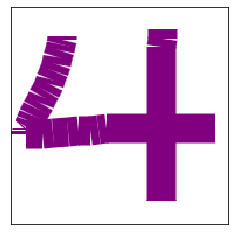

In [16]:
# See what hand-drawn digit the sample data represents

rgba_arr = np.asarray(sample_cavas_data["data"]).astype('uint8')
n = sample_cavas_data["height"]
plt.figure()
plt.imshow( rgba_arr.reshape(n, n, 4))
plt.xticks([])
plt.yticks([])
plt.show()

## <a id="upload"></a> 4. Create a deployable function

The basics of creating and deploying functions in Watson Machine Learning are given here:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deploy-functions.html" target="_blank" rel="noopener noreferrer">Creating and deploying functions</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-functions.html" target="_blank" rel="noopener noreferrer">Implementation details of deployable functions</a>


### 4.1 Define the function
1. Define a Python closure with an inner function named "score".
2. Use default parameters to save your Watson Machine Learning credentials and the model deployment ID with the deployed function.
3. Process the canvas data (reshape and normalize) and then send the processed data to the model deployment.
4. Process the results from the model deployment so the deployed function returns simpler results.
5. Implement error handling so the function will behave gracefully if there is an error.

In [17]:
ai_parms = {"wml_credentials": wml_credentials, "space_id": space_id, "model_deployment_id": model_deployment_id}

def my_deployable_function( parms=ai_parms ):
    def getRGBAArr(canvas_data):
        import numpy as np
        dimension = canvas_data["height"]
        rgba_data = canvas_data["data"]
        rgba_arr  = np.asarray(rgba_data).astype('uint8')
        return rgba_arr.reshape(dimension, dimension, 4)
        
    def getNormAlphaList(img):
        import numpy as np
        alpha_arr       = np.array(img.split()[-1])
        norm_alpha_arr  = alpha_arr / 255
        norm_alpha_list = norm_alpha_arr.reshape(1, 784).tolist()
        return norm_alpha_list
        
    def score(function_payload):
            
        try:
            
            from PIL import Image
            canvas_data   = function_payload["input_data"][0]["values"][0]           # Read the payload received by the function
            rgba_arr      = getRGBAArr(canvas_data)               # Create an array object with the required shape
            img           = Image.fromarray(rgba_arr, 'RGBA')     # Create an image object that can be resized
            sm_img        = img.resize((28, 28), Image.LANCZOS) # Resize the image to 28 x 28 pixels
            alpha_list    = getNormAlphaList(sm_img)              # Create a 1 x 784 array of values between 0 and 1
            model_payload = {"input_data": [{"values" : alpha_list}]}               # Create a payload to be sent to the model
                    
            #print( "Payload for model:" ) # For debugging purposes
            #print( model_payload )        # For debugging purposes
                    
            from ibm_watson_machine_learning import APIClient
            client       = APIClient(parms["wml_credentials"])
            client.set.default_space(parms["space_id"])
            model_result = client.deployments.score(parms["model_deployment_id"], model_payload)
            digit_class  = model_result["predictions"][0]["values"][0]
                    
            return model_result
        
        except Exception as e:
            
            return {'predictions': [{'values': [repr(e)]}]}
            #return {"error" : repr(e)}


    return score

### 4.2 Test locally
You can test your function in the notebook before deploying the function.

To see debugging info:
1. Uncomment the print statements inside the score function
2. Rerun the cell defining the function
3. When you rerun the this cell, you will see the debugging info

In [18]:
# Pass the sample canvas data to the function as a test

func_result = my_deployable_function()({"input_data": [{"values": [sample_cavas_data]}]})
print(func_result)

{'predictions': [{'id': 'classes', 'values': [4]}]}


## <a id="deploy"></a> 5. Store and deploy the function
Before you can deploy the function, you must store the function in your Watson Machine Learning repository.

In [19]:
# Look up software specification for the deployable function

sofware_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.9")

In [20]:
# Store the deployable function in your Watson Machine Learning repository

meta_data = {
    client.repository.FunctionMetaNames.NAME: 'MNIST deployable function',
    client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

function_details = client.repository.store_function(meta_props=meta_data, function=my_deployable_function)

In [21]:
# Get published function ID

function_uid = client.repository.get_function_uid(function_details)

In [22]:
# Deploy the stored function

metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST function deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

function_deployment_details = client.deployments.create(function_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: 'cf738c56-0214-4f8c-9d38-1941bbdea977' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f709a93b-c9d8-46b2-900d-79a9849c9f9c'
------------------------------------------------------------------------------------------------




## <a id="score"></a> 6. Test the deployed function

You can use the Watson Machine Learning Python client or REST API to send data to your function deployment for processing in exactly the same way you send data to model deployments for processing.

In [23]:
# Get the endpoint URL of the function deployment just created

function_deployment_id = client.deployments.get_uid(function_deployment_details)
function_deployment_endpoint_url = client.deployments.get_scoring_href(function_deployment_details)
print(function_deployment_id)
print(function_deployment_endpoint_url)

f709a93b-c9d8-46b2-900d-79a9849c9f9c
https://wmlgmc-cpd-wmlgmc.apps.wmlautoai.cp.fyre.ibm.com/ml/v4/deployments/f709a93b-c9d8-46b2-900d-79a9849c9f9c/predictions


In [24]:
payload = {"input_data": [{"values": [sample_cavas_data]}]}

### 6.1 Watson Machine Learning Python client

In [25]:
result = client.deployments.score(function_deployment_id, payload)
if "error" in result:
    print(result["error"])
else:
    print(result)

{'predictions': [{'id': 'classes', 'values': [4]}]}


## <a id="cleanup"></a> 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps
In this notebook, you created a Python function that receives HTML canvas image data and then processes and sends that data to a model trained to recognize handwritten digits.

To learn how you can use this deployed function in a web app, see:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-nodejs-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Sample Node.js app that recognizes hand-drawn digits</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-flask-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Sample Python Flask app that recognizes hand-drawn digits</a>

### <a id="authors"></a>Authors

**Sarah Packowski** is a member of the IBM Watson Studio Content Design team in Canada.


<hr>
Copyright &copy; IBM Corp. 2018-2021. This notebook and its source code are released under the terms of the MIT License.